# CosmoFlow Benchmark Scaling Analysis

In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

def compute_mean_time(r):
    return r[r.epoch>0].time.mean()

def get_num_samples(config, ranks):
    dconf = config['data']
    n = dconf['n_train'] + dconf['n_valid']
    if not dconf['shard']:
        n *= ranks
    return n

def get_scaling_results(path_pattern, ranks):
    """
    Loops over ranks with specified file path pattern and computes scaling metrics.
    Returns results in a dataframe.
    """
    configs, results = [], []
    for r in ranks:
        result_dir = path_pattern % r
        configs.append(load_config(result_dir))
        results.append(load_result(result_dir).assign(ranks=r))
    samples = np.array([get_num_samples(c,r) for (c,r) in zip(configs, ranks)])    
    times = np.array([compute_mean_time(r) for r in results])
    throughputs = samples / times
    ideal = ranks * throughputs[0]
    eff = throughputs / ideal
    return pd.DataFrame(dict(ranks=ranks, samples=samples,
                             times=times, throughputs=throughputs,
                             ideal=ideal, eff=eff))

In [5]:
%env MLPERF_HPC_ROOT=/home/lukasd/src/mlperf

%env MLPERF_COSMO_GPU_TIMESTAMP=2020-08-03_12-43-00_daint101
%env MLPERF_COSMO_CPU_TIMESTAMP=2020-08-03_15-15-51_daint101

env: MLPERF_HPC_ROOT=/home/lukasd/src/mlperf
env: MLPERF_COSMO_GPU_TIMESTAMP=2020-08-03_12-43-00_daint101
env: MLPERF_COSMO_CPU_TIMESTAMP=2020-08-03_15-15-51_daint101


In [6]:
%%bash

echo "## GPU experiments ##"
ls -l ${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_GPU_TIMESTAMP}
echo ""
echo "## CPU experiments ##"
ls -l ${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_CPU_TIMESTAMP}


## GPU experiments ##
total 56
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:49 scaling-gpu-dummy-n1
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:51 scaling-gpu-dummy-n16
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:51 scaling-gpu-dummy-n2
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:50 scaling-gpu-dummy-n32
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:51 scaling-gpu-dummy-n4
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:48 scaling-gpu-dummy-n64
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:51 scaling-gpu-dummy-n8
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:48 scaling-gpu-n1
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:52 scaling-gpu-n16
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:50 scaling-gpu-n2
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:49 scaling-gpu-n32
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:49 scaling-gpu-n4
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:52 scaling-gpu-n64
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 12:50 scaling-gpu-n8

## CPU experiments ##
total 56
drwxr-xr-x 3 lukasd lukasd 4096 Aug  3 16:33 scal

## Daint GPU scaling

In [7]:
results_gpu = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_GPU_TIMESTAMP}/scaling-gpu-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

results_gpu_dummy = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_GPU_TIMESTAMP}/scaling-gpu-dummy-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

In [8]:
# Summary table
results_gpu.merge(results_gpu_dummy, on='ranks', suffixes=(None,'_dummy'))

,ranks,samples,times,throughputs,ideal,eff,samples_dummy,times_dummy,throughputs_dummy,ideal_dummy,eff_dummy
0,1,512,27.585474,18.560493,18.560493,1.000000,512,30.249063,16.926144,16.926144,1.000000
1,2,1024,28.193059,36.320997,37.120987,0.978449,1024,30.785995,33.261878,33.852288,0.982559
2,4,2048,28.447324,71.992712,74.241973,0.969704,2048,31.511835,64.991455,67.704575,0.959927
3,8,4096,28.971968,141.378040,148.483947,0.952144,4096,31.511445,129.984516,135.409151,0.959939
4,16,8192,29.003337,282.450262,296.967894,0.951114,8192,31.658819,258.758865,270.818302,0.955470
5,32,16384,29.266624,559.818575,593.935788,0.942557,16384,32.089008,510.579818,541.636603,0.942661
6,64,32768,29.642493,1105.440073,1187.871575,0.930606,32768,32.124002,1020.047261,1083.273206,0.941634


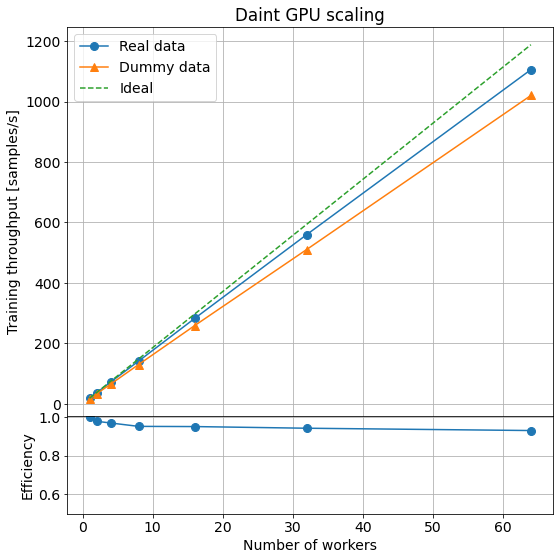

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.set_title('Daint GPU scaling')
ax0.plot(results_gpu.ranks, results_gpu.throughputs, 'o-', ms=8, label='Real data')
ax0.plot(results_gpu_dummy.ranks, results_gpu_dummy.throughputs, '^-', ms=8, label='Dummy data')
ax0.plot(results_gpu.ranks, results_gpu.ideal, '--', label='Ideal')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results_gpu.ranks, results_gpu.eff, 'o-', ms=8)
#ax1.plot(results_gpu_dummy.ranks, results_gpu.eff, '^-', ms=8)
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.5)
ax1.grid()

plt.tight_layout()



## Daint CPU scaling

In [16]:
results = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_CPU_TIMESTAMP}/scaling-cpu-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

results_dummy = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_CPU_TIMESTAMP}/scaling-cpu-dummy-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

In [12]:
%%script false --no-raise-error

path_pattern = os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_CPU_TIMESTAMP}/scaling-cpu-dummy-n%i')
ranks=np.array([1, 2, 4]) #, 8, 16, 32, 64])


def compute_mean_time(r):
    return r[r.epoch>0].time.mean()

configs, results = [], []
for r in ranks:
    result_dir = path_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))
samples = np.array([get_num_samples(c,r) for (c,r) in zip(configs, ranks)])    
times = np.array([r.time.mean() for r in results])
throughputs = samples / times
ideal = ranks * throughputs[0]
eff = throughputs / ideal
pd.DataFrame(dict(ranks=ranks, samples=samples,
                  times=times, throughputs=throughputs,
                  ideal=ideal, eff=eff))


In [13]:
%%script false --no-raise-error

dconf = configs[0]['data']
n = dconf['n_train'] + dconf['n_valid']
if not dconf['shard']:
    n *= ranks
n

In [14]:
# Summary table
results.merge(results_dummy, on='ranks', suffixes=(None,'_dummy'))

,ranks,samples,times,throughputs,ideal,eff,samples_dummy,times_dummy,throughputs_dummy,ideal_dummy,eff_dummy
0,1,64,420.400453,0.152236,0.152236,1.000000,64,416.331779,0.153724,0.153724,1.000000
1,2,128,488.072858,0.262256,0.304472,0.861348,128,484.396916,0.264246,0.307447,0.859485
2,4,256,484.418939,0.528468,0.608943,0.867845,256,487.066389,0.525596,0.614894,0.854774
3,8,512,507.745656,1.008379,1.217886,0.827974,512,513.707405,0.996676,1.229788,0.810445
4,16,1024,525.172876,1.949834,2.435773,0.800499,1024,527.347751,1.941793,2.459577,0.789482
5,32,2048,531.322841,3.854530,4.871546,0.791234,2048,523.755011,3.910225,4.919154,0.794898
6,64,4096,530.816406,7.716416,9.743091,0.791988,4096,533.304467,7.680416,9.838307,0.780664


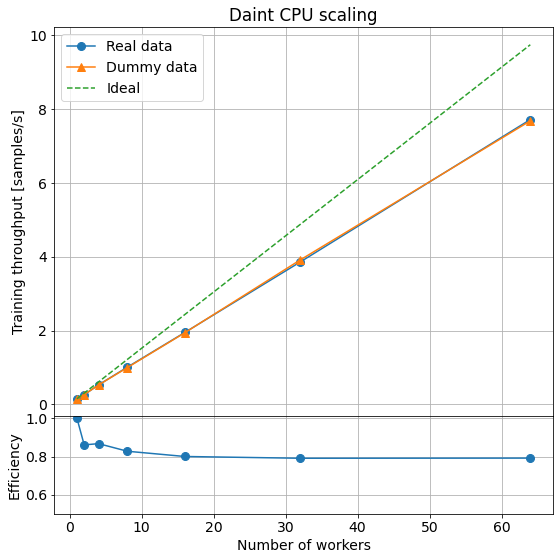

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.set_title('Daint CPU scaling')
ax0.plot(results.ranks, results.throughputs, 'o-', ms=8, label='Real data')
ax0.plot(results_dummy.ranks, results_dummy.throughputs, '^-', ms=8, label='Dummy data')
ax0.plot(results.ranks, results.ideal, '--', label='Ideal')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.eff, 'o-', ms=8)
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.5)
ax1.grid()

plt.tight_layout()

## Cori GPU scaling

In [6]:
results_cgpu = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_GPU_TIMESTAMP}/scaling-cgpu-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

results_cgpu_dummy = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_GPU_TIMESTAMP}/scaling-cgpu-dummy-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

In [7]:
# Summary table
results_cgpu.merge(results_cgpu_dummy, on='ranks', suffixes=(None,'_dummy'))

,ranks,samples,times,throughputs,ideal,eff,samples_dummy,times_dummy,throughputs_dummy,ideal_dummy,eff_dummy
0,1,512,12.893975,39.708467,39.708467,1.000000,512,11.679684,43.836801,43.836801,1.000000
1,2,1024,12.833653,79.790221,79.416934,1.004700,1024,12.799187,80.005081,87.673602,0.912533
2,4,2048,15.058182,136.005793,158.833869,0.856277,2048,12.773162,160.336178,175.347205,0.914393
3,8,4096,18.533700,221.002820,317.667738,0.695704,4096,13.916620,294.324333,350.694410,0.839262
4,16,8192,19.009904,430.933267,635.335475,0.678277,8192,15.088690,542.923196,701.388820,0.774069
5,32,16384,19.279959,849.794357,1270.670951,0.668776,16384,15.837898,1034.480685,1402.777639,0.737452
6,64,32768,22.272266,1471.246792,2541.341901,0.578925,32768,16.143928,2029.741404,2805.555279,0.723472


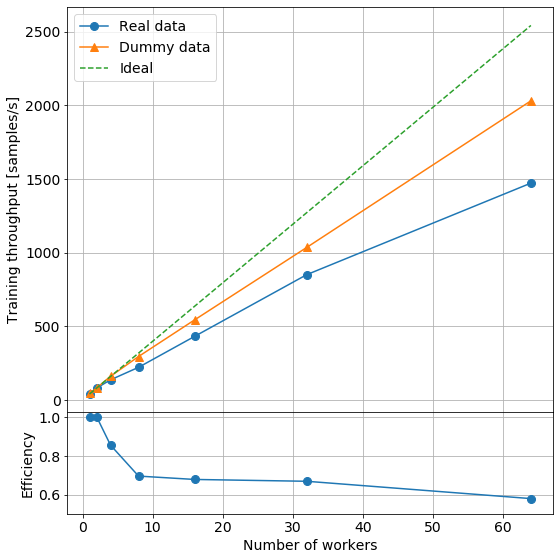

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.plot(results_cgpu.ranks, results_cgpu.throughputs, 'o-', ms=8, label='Real data')
ax0.plot(results_cgpu_dummy.ranks, results_cgpu_dummy.throughputs, '^-', ms=8, label='Dummy data')
ax0.plot(results_cgpu.ranks, results_cgpu.ideal, '--', label='Ideal')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results_cgpu.ranks, results_cgpu.eff, 'o-', ms=8)
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.5)
ax1.grid()

plt.tight_layout()

## Cori CPU scaling

In [9]:
results = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_CPU_TIMESTAMP}/scaling-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]))

results_dummy = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_CPU_TIMESTAMP}/scaling-dummy-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]))

In [10]:
# Summary table
results.merge(results_dummy, on='ranks', suffixes=(None,'_dummy'))

,ranks,samples,times,throughputs,ideal,eff,samples_dummy,times_dummy,throughputs_dummy,ideal_dummy,eff_dummy
0,1,64,17.317688,3.695643,3.695643,1.000000,64,17.458997,3.665732,3.665732,1.000000
1,2,128,18.528065,6.908439,7.391287,0.934673,128,18.280915,7.001838,7.331463,0.955040
2,4,256,18.764791,13.642571,14.782574,0.922882,256,18.746286,13.656038,14.662927,0.931331
3,8,512,18.910925,27.074297,29.565148,0.915750,512,18.912969,27.071371,29.325853,0.923123
4,16,1024,19.091434,53.636619,59.130295,0.907092,1024,19.109365,53.586290,58.651707,0.913636
5,32,2048,19.181881,106.767423,118.260591,0.902815,2048,19.299099,106.118943,117.303414,0.904653
6,64,4096,19.419858,210.918124,236.521181,0.891752,4096,19.439863,210.701077,234.606828,0.898103
7,128,8192,19.644668,417.008818,473.042362,0.881546,8192,19.615880,417.620819,469.213656,0.890044
8,256,16384,20.561300,796.836774,946.084725,0.842247,16384,20.052720,817.046250,938.427312,0.870655
9,512,32768,21.172881,1547.640124,1892.169450,0.817918,32768,20.588671,1591.554910,1876.854623,0.847991


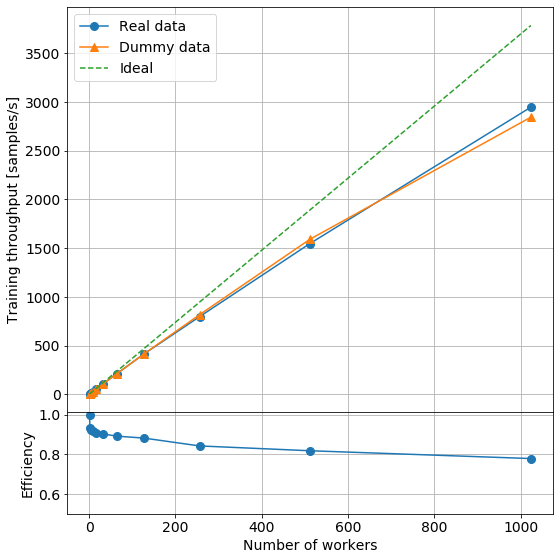

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.plot(results.ranks, results.throughputs, 'o-', ms=8, label='Real data')
ax0.plot(results_dummy.ranks, results_dummy.throughputs, '^-', ms=8, label='Dummy data')
ax0.plot(results.ranks, results.ideal, '--', label='Ideal')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.eff, 'o-', ms=8)
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.5)
ax1.grid()

plt.tight_layout()

## Discussion

The scaling performance looks pretty decent, achieving about 80% of ideal throughput speedup at 1k CPU nodes.

The data pipeline seems well tuned for CPU. We are not even using the Burst Buffer, but the scaling is about as good as with dummy data.
However, it seems there may be some room for improvement there on the GPU system.

